# IMPORTS

In [11]:
import warnings
warnings.simplefilter("ignore")

In [12]:
import re
import sqlite3
import pickle
import s3fs
import os

import pandas                as pd
import numpy                 as np
import umap.umap_            as umap
import seaborn               as sns
import matplotlib.pyplot     as plt

from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import silhouette_score, silhouette_samples
from sklearn.mixture         import GaussianMixture

from sqlalchemy import create_engine

# LOADING DATA

In [15]:
# loading the csv file and choosing the encoding
df = pd.read_csv('data/Ecommerce.csv', encoding='cp437')

# remove the empty column
df = df.drop(columns=['Unnamed: 8'], axis=1)

## LOADING THE AWS S3 KEYS

In [16]:
# loading the S3 keys
AWS_ACCESS_KEY_ID = os.environ.get('AWS_ACCESS_KEY_ID_VIPS')
AWS_SECRET_ACCESS_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY_VIPS')

# building a object to access the S3 bucket
fs = s3fs.S3FileSystem(anon=False, key=AWS_ACCESS_KEY_ID, secret=AWS_SECRET_ACCESS_KEY)

## RENAME COLUMNS

In [17]:
# checking the columns name
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [18]:
# renaming the columns names
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']
df.columns = cols_new

## DATASET DIMENSION

In [19]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns')

The dataset has 541909 rows and 8 columns


## DATA SUMMARY

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   description   540455 non-null  object 
 3   quantity      541909 non-null  int64  
 4   invoice_date  541909 non-null  object 
 5   unit_price    541909 non-null  float64
 6   customer_id   406829 non-null  float64
 7   country       541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## CHECKING MISSING DATA

In [21]:
# sum of the missing data by feature
df.isnull().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [22]:
# percentage of missing data
percentage_na = ((df.isnull().sum().sort_values(ascending=False) / len(df)) * 100).map('{:.2f}%'.format)
percentage_na

customer_id     24.93%
description      0.27%
invoice_no       0.00%
stock_code       0.00%
quantity         0.00%
invoice_date     0.00%
unit_price       0.00%
country          0.00%
dtype: object

## MISSING DATA ANALYSIS

In [23]:
# criando dataframes para comparação de customer_id
df_missing = df.loc[df['customer_id'].isna(), :]
df_not_missing = df.loc[~df['customer_id'].isna(), :]

In [24]:
print(f'Quantity of customer_id missing: {df_missing.shape[0]}')
print(f'Quantity of customer_id not missing: {df_not_missing.shape[0]}')

Quantity of customer_id missing: 135080
Quantity of customer_id not missing: 406829


In [25]:
# criando lista com o invoice_no dos dados faltantes
invoice_no_missing = df_missing['invoice_no'].drop_duplicates().tolist()

# verificando se há invoice_no correspondentes aos dados sem customer_id
df_not_missing['invoice_no'].isin(invoice_no_missing).value_counts()

invoice_no
False    406829
Name: count, dtype: int64

In [26]:
df = df.dropna()

In [27]:
df.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## CHANGING DATA TYPES

In [28]:
# invoice_date from object to datetime
df['invoice_date'] = pd.to_datetime(df['invoice_date'], format='%d-%b-%y')

# customer_id from float64 to int64
df['customer_id'] = df['customer_id'].astype(int)

In [29]:
df.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

# FILTERING VARIABLES

In [30]:
df1 = df.copy()

In [31]:
# numeric feature unit_price with values above 0.04
df1 = df1.loc[df1['unit_price'] >= 0.04, :]

# categorical feature stock_code remove values
df1 = df1[~df1['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm',
'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# categorical feature description completely remove
df1 = df1.drop(columns='description', axis=1)

# categorical feature country remove unspecified and non-country values
df1 = df1[~df1['country'].isin(['European Community', 'Unspecified'])]

# users with highly divergent results
df1 = df1[~df1['customer_id'].isin([16446])]

# numeric feature quantity split into 2 new dataframes
df1_returns = df1.loc[df1['quantity'] < 0, :]
df1_sales = df1.loc[df1['quantity'] > 0, :]

# FEATURE ENGINEERING

In [32]:
df2 = df1.copy()

In [33]:
# reference table
df_ref = df2.drop(['invoice_no', 'stock_code', 'quantity',  
                   'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

## GROSS REVENUE

In [34]:
# gross_revenue -> quantity * unit_price = gross_revenue
df1_sales.loc[:, 'gross_revenue'] = df1_sales.loc[:, 'quantity'] * df1_sales.loc[:, 'unit_price']

In [35]:
# monetary value
df_mv = df1_sales.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_mv, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
dtype: int64

## RECENCY

In [36]:
# recency - difference between the maximum date in the dataset and the customer's last purchase date
df_recency = df1_sales[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

## TOTAL ORDERS

In [37]:
# total orders - the number of times the customer made a purchase within a specified time period
df_quantity = df1_sales.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'total_orders'})
df_ref = pd.merge(df_ref, df_quantity, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
total_orders     27
dtype: int64

## FREQUENCY

In [38]:
df_frequency_aux = (df1_sales[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                                      .groupby('customer_id')
                                                                      .agg(max_ = ('invoice_date', 'max'),
                                                                           min_ = ('invoice_date', 'min'),
                                                                           days_= ('invoice_date', lambda x: ((x.max() - x.min()).days)+1),
                                                                           buy_ = ('invoice_no', 'count'))).reset_index()


In [39]:
df_frequency_aux = (df1_sales[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                                      .groupby('customer_id')
                                                                      .agg(max_ = ('invoice_date', 'max'),
                                                                           min_ = ('invoice_date', 'min'),
                                                                           days_= ('invoice_date', lambda x: ((x.max() - x.min()).days)+1),
                                                                           buy_ = ('invoice_no', 'count'))).reset_index()

# frequency
df_frequency_aux['frequency'] = df_frequency_aux[['buy_', 'days_']].apply(lambda x: x['buy_']/x['days_'] if x['days_'] != 0 else 0, axis=1)

# merge
df_ref = pd.merge(df_ref, df_frequency_aux[['customer_id', 'frequency']], on='customer_id', how='left')

In [40]:
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
total_orders     27
frequency        27
dtype: int64

## RETURNS QUANTITY

In [41]:
df_returns = df1_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qty_returns'})
df_returns['qty_returns'] = df_returns['qty_returns'] * -1

In [42]:
df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['qty_returns'].isna(), 'qty_returns'] = 0

df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
total_orders     27
frequency        27
qty_returns       0
dtype: int64

In [43]:
df_ref = df_ref.loc[df_ref['total_orders'] > 1, :] 

# EDA

In [44]:
df3 = df_ref.dropna()
df3.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
total_orders     0
frequency        0
qty_returns      0
dtype: int64

## DATA SPACE STUDY

In [45]:
# dataset with the selected features
features_selected = ['customer_id', 'gross_revenue', 'recency_days', 'total_orders', 'frequency', 'qty_returns']
df_data_space = df3[features_selected].drop(columns=['customer_id'], axis=1).copy()

### TREE-BASED EMBEDDING

In [46]:
# training datasets
X = df_data_space.drop(columns=['gross_revenue'])
y = df_data_space['gross_revenue']

# model
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)

# model training
rf_model.fit(X, y)

# saving the model as a pickle file
#pickle.dump(rf_model, open('/home/gabriel/repos/cluster_vips/model/rf_model.pkl', 'wb'))

# uploading to S3
#pickle.dump(rf_model, fs.open('s3://cluster-vips-dataset/rf_model.pkl', 'wb'))

# dataframe with leaf nodes
df_leaf = pd.DataFrame(rf_model.apply(X))

In [47]:
# reduce dimensionality
reducer = umap.UMAP(random_state=42, n_neighbors=25, min_dist=0.1, n_components=2)
embedding = reducer.fit_transform(df_leaf)

# saving the dimensionality reducer as a pickle file
#pickle.dump(reducer, open('/home/gabriel/repos/cluster_vips/model/umap_reducer.pkl', 'wb'))

# uploading to S3
#pickle.dump(reducer, fs.open('s3://cluster-vips-dataset/umap_reducer.pkl', 'wb'))

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# MODEL TRAINING

In [48]:
X = df_tree.copy()

In [49]:
clusters = np.arange(2, 26)

## MODEL DEFINITION

In [50]:
# model definition
k = 10
gmm_model = GaussianMixture(n_components=k, n_init=100, init_params='k-means++', max_iter=1000, random_state=42)

# model training
gmm_model.fit(X)

# saving the gmm model as a pickle file
#pickle.dump(gmm_model, open('/home/gabriel/repos/cluster_vips/model/gmm_model.pkl', 'wb'))

# uploading to S3
#pickle.dump(gmm_model, fs.open('s3://cluster-vips-dataset/gmm_model.pkl', 'wb'))

# clustering
labels = gmm_model.predict(X)

## CLUSTER VALIDATION

In [51]:
# SS (Silhouette Score)
print(f'SS Results: {silhouette_score(X, labels, metric="euclidean")}')

SS Results: 0.6231642961502075


# ANALYSIS

In [52]:
df_cluster = df3.copy()

In [53]:
df_cluster['cluster'] = labels
df_cluster.head()

,customer_id,gross_revenue,recency_days,total_orders,frequency,qty_returns,cluster
0,17850,5391.21,372.0,34.0,17.000000,40.0,2
1,13047,3232.59,56.0,9.0,0.028302,35.0,5
2,12583,6705.38,2.0,15.0,0.040323,50.0,2
3,13748,948.25,95.0,5.0,0.017921,0.0,6
4,15100,876.00,333.0,3.0,0.073171,22.0,3


## CLUSTERING VISUAL INSPECTION

In [54]:
df_7 = X.copy()
df_7['cluster'] = labels
df_7.head()

,embedding_x,embedding_y,cluster
0,3.491432,22.688183,2
1,-1.359769,10.505424,5
2,2.006280,19.783897,2
3,-4.024026,-2.139170,6
4,18.666782,-6.345514,3


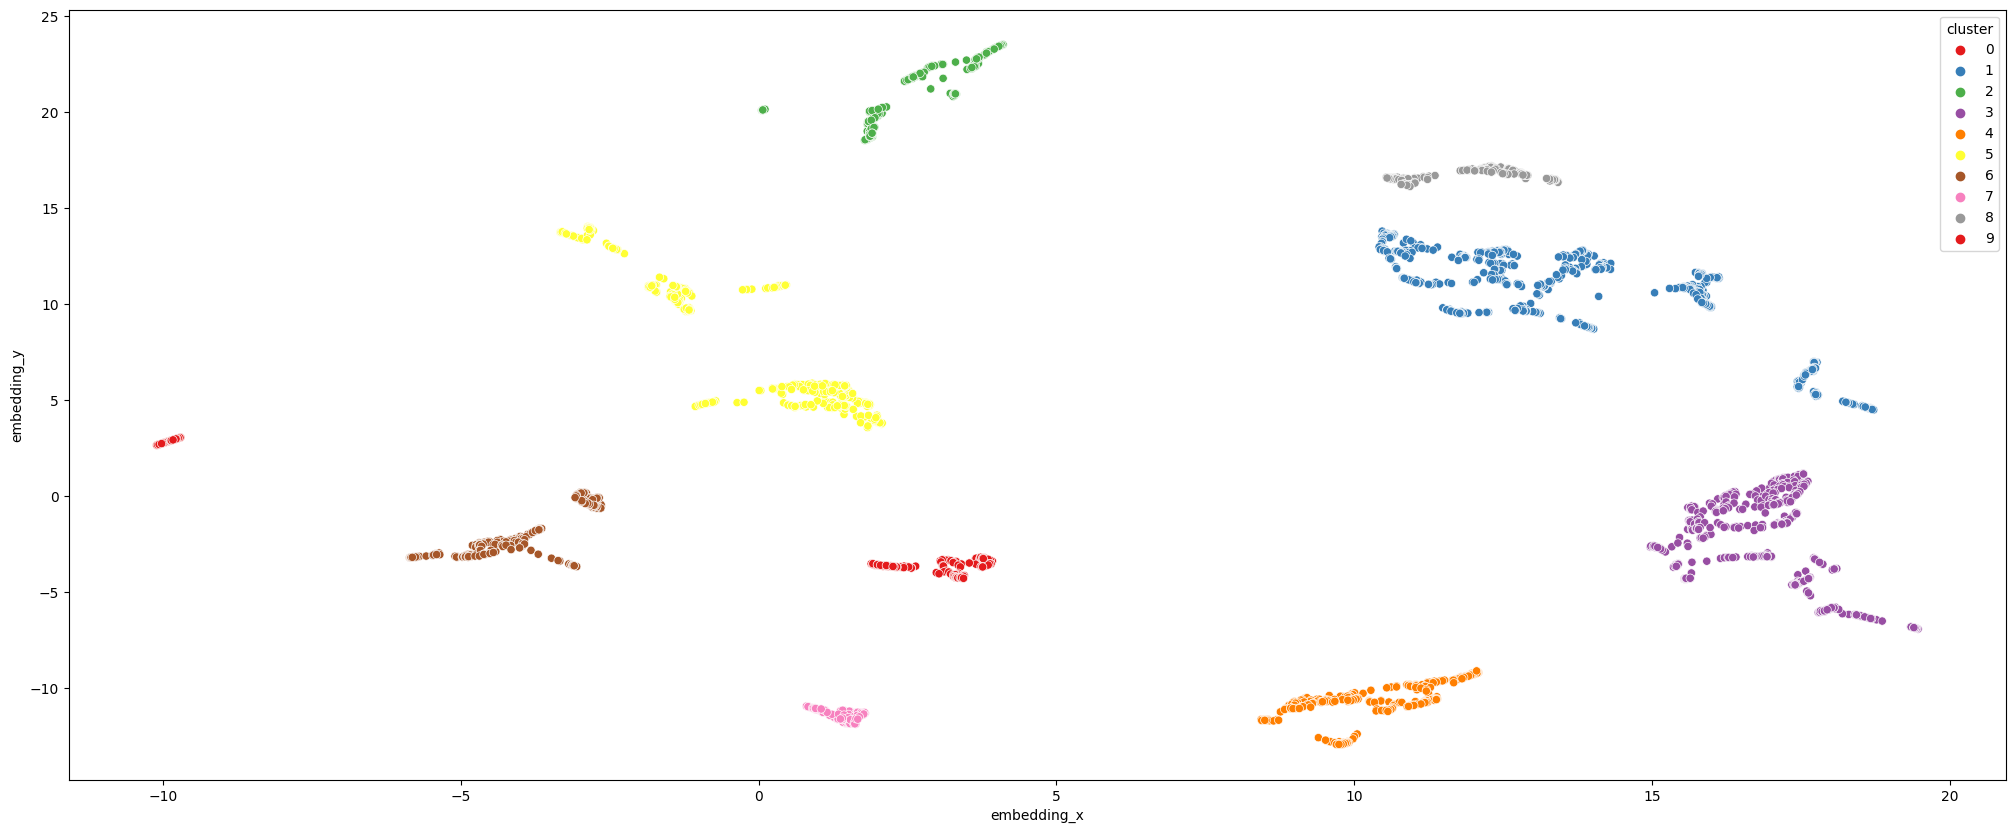

In [55]:
plt.figure(figsize=(25,10))
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df_7, palette='Set1');

## CLUSTER PROFILE

In [56]:
# number of customer
df_cluster_profile = df_cluster[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster_profile['perc_customer'] = 100*(df_cluster_profile['customer_id']/df_cluster_profile['customer_id'].sum())

# avg gross revenue
df_avg_gross_revenue = df_cluster[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster_profile = pd.merge(df_cluster_profile, df_avg_gross_revenue, how='inner', on='cluster')

# avg recency days
df_avg_recency_days = df_cluster[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster_profile = pd.merge(df_cluster_profile, df_avg_recency_days, how='inner', on='cluster')

# avg orders
df_avg_orders = df_cluster[['total_orders', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster_profile = pd.merge(df_cluster_profile, df_avg_orders, how='inner', on='cluster')

# avg frequency
df_avg_frequency = df_cluster[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster_profile = pd.merge(df_cluster_profile, df_avg_frequency, how='inner', on='cluster')

# avg quantity of returns
df_avg_qty_returns = df_cluster[['qty_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster_profile = pd.merge(df_cluster_profile, df_avg_qty_returns, how='inner', on='cluster')

In [57]:
df_cluster_profile.sort_values(by='gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,total_orders,frequency,qty_returns
2,2,251,8.888102,15857.935976,11.884462,24.266932,0.138825,218.402390
5,5,481,17.032578,3303.880437,27.586279,8.480249,0.041839,53.012474
0,0,140,4.957507,2031.789571,41.400000,5.985714,0.061290,2.400000
6,6,238,8.427762,1946.825462,42.983193,4.966387,0.076367,12.915966
7,7,100,3.541076,1740.114400,52.940000,4.000000,0.027619,31.830000
4,4,294,10.410765,1350.988299,54.190476,3.979592,0.038939,7.581633
3,3,498,17.634561,1067.999237,68.598394,3.000000,0.035532,8.269076
9,9,49,1.735127,948.983878,123.755102,2.000000,0.138263,64.693878
1,1,630,22.308782,652.809317,100.579365,2.000000,0.197325,1.174603
8,8,143,5.063739,615.029650,48.916084,2.000000,0.007932,0.020979


Clusters:
- VIP (Highest Rank)
- Platinum
- Gold
- Silver
- Bronze
- Elite
- Preferred
- Standard
- Basic
- Newcomer (Lowest Rank)

# DEPLOY

In [58]:
df_cluster.head()

,customer_id,gross_revenue,recency_days,total_orders,frequency,qty_returns,cluster
0,17850,5391.21,372.0,34.0,17.000000,40.0,2
1,13047,3232.59,56.0,9.0,0.028302,35.0,5
2,12583,6705.38,2.0,15.0,0.040323,50.0,2
3,13748,948.25,95.0,5.0,0.017921,0.0,6
4,15100,876.00,333.0,3.0,0.073171,22.0,3


In [59]:
df_cluster.dtypes

customer_id        int64
gross_revenue    float64
recency_days     float64
total_orders     float64
frequency        float64
qty_returns      float64
cluster            int64
dtype: object

## UPLOADING IT TO A SQLITE DATABASE

In [60]:
df_cluster['recency_days'] = df_cluster['recency_days'].astype(int)
df_cluster['total_orders'] = df_cluster['total_orders'].astype(int)
df_cluster['qty_returns'] = df_cluster['qty_returns'].astype(int)

In [61]:
# # creating tables
# query_create_table_vip = """
#     CREATE TABLE vips (
#         customer_id      INTEGER,
#         gross_revenue    REAL,
#         recency_days     INTEGER,
#         total_orders     INTEGER,
#         frequency        REAL,
#         qty_returns      INTEGER,
#         cluster          INTEGER     
#     )
# """

# conn = sqlite3.connect('vip_clients_db.sqlite')
# conn.execute(query_create_table_vip)
# conn.commit()
# conn.close()

# # inserting into a database
# conn = create_engine('sqlite:///vip_clients_db.sqlite')
# df_cluster.to_sql('vips', con=conn, if_exists='append', index=False)

In [62]:
# # consulting the database
# query = """
#     SELECT * FROM vips
# """

# df = pd.read_sql_query(query, conn)